# Emotion Detector

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.15.0


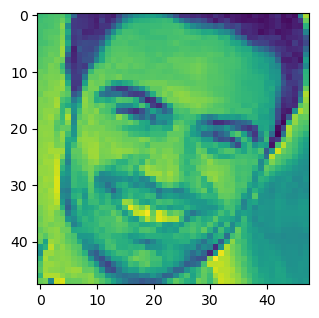

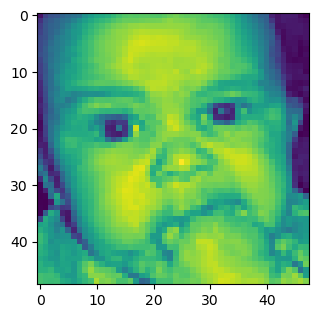

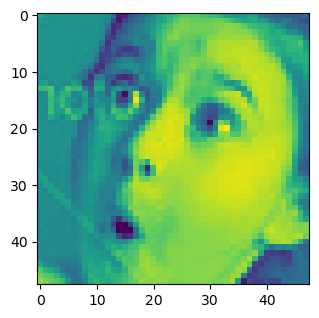

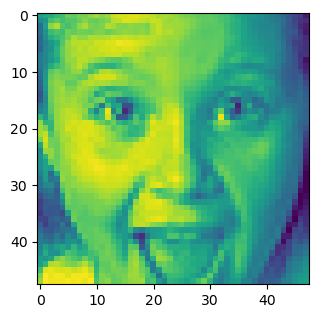

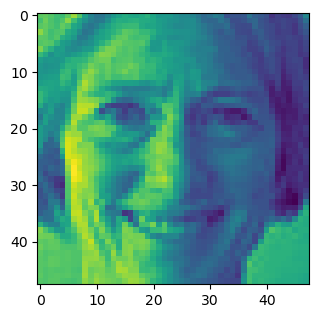

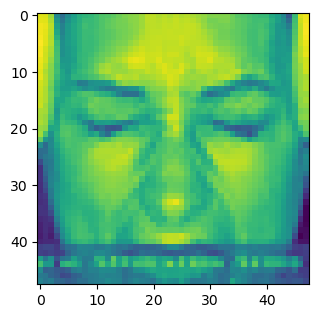

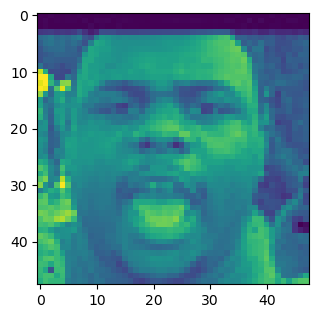

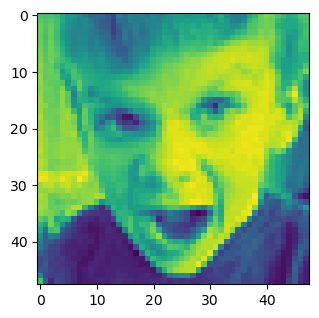

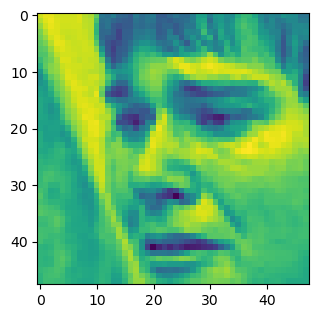

In [6]:
images = glob("train/**/**")

if images:
    for i in range(9):
        image = random.choice(images)
        plt.figure(figsize=(12, 12))
        plt.subplot(331 + i)
        plt.imshow(plt.imread(image))
        plt.show()

In [45]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
                                                    

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Defining Model

In [36]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "Same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [40]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [51]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation ="softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [52]:
model = model_fer((48,48,1))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_20 (Ba  (None, 48, 48, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_19 (Activation)  (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 24, 24, 128)       0   

##### Initializing the Model

In [53]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose=1)
callbacks = [checkpoint]

##### Traning the Model

In [54]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


448/448 [==============================] - ETA: 0s - loss: 1.6333 - accuracy: 0.3813
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 794s 2s/step - loss: 1.6333 - accuracy: 0.3813 - val_loss: 1.7206 - val_accuracy: 0.2630
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3427 - accuracy: 0.4903
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 307s 682ms/step - loss: 1.3427 - accuracy: 0.4903 - val_loss: 1.5354 - val_accuracy: 0.3838
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.5543
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 293s 654ms/step - loss: 1.1852 - accuracy: 0.5543 - val_loss: 1.5218 - val_accuracy: 0.4325
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.6091
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 2

##### Model Evaluation

In [55]:
model.evaluate(validation_generator)

113/113 [==============================] - 13s 115ms/step - loss: 2.0144 - accuracy: 0.4997


[2.0144312381744385, 0.49972137808799744]

##### Plotting Loss

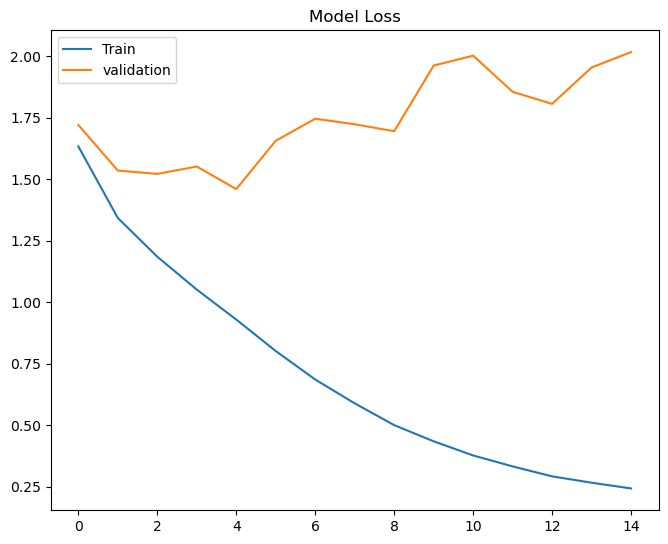

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

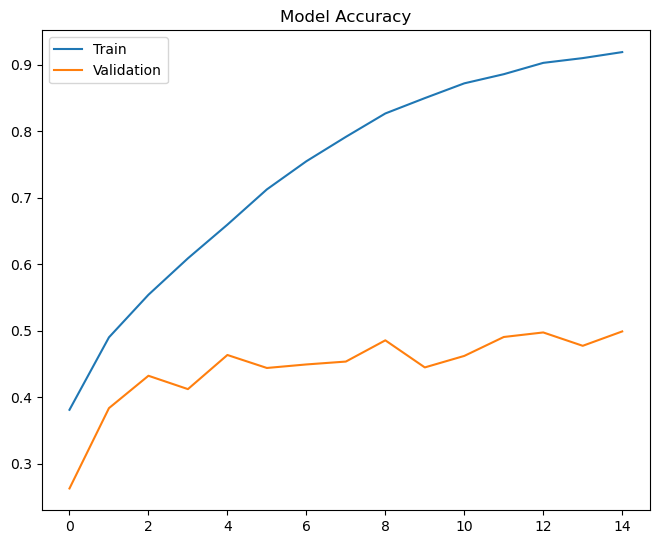

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

##### Saving Model

In [59]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)